In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import pickle
import glob
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from scipy import stats

import bayesianchangepoint as bcp
from scipy.stats import beta

TODO: pour le match, trouver quelque chose de mieux que le R2?

TODO: voir si le match pour chaque sujet varie en fonction dde h / mode

TODO: autodétruire cette cellule

In [2]:
t_titre = 35/2 #35
t_label = 25/2 #25
fig_width = 15/2 #15
colors = ['black','dimgrey','grey','darkgrey','silver','rosybrown','lightcoral','indianred','firebrick','brown','darkred','red']

In [3]:
liste = []
for fname in glob.glob('data/*pkl'):
    a = fname.split('/')[1].split('.')[0].split('_')
    liste.append(a)

In [4]:
exp = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK'] :
        a = 'data/%s_%s_%s_%s.pkl'%(liste[x][0], liste[x][1],liste[x][2],liste[x][3])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            exp.append(b)

In [5]:
param = []
for x in range(len(liste)) :
    if liste[x][0]=='pari' and liste[x][1] in ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN','YK'] :
        a = 'parametre/param_Fit_%s.pkl'%(liste[x][1])
        with open(a, 'rb') as fichier :
            b = pickle.load(fichier, encoding='latin1')
            param.append(b)

In [6]:
p_hat_bcp_e = [[],[],[],[],[],[],[],[],[],[],[],[]]
p_hat_bcp_m = [[],[],[],[],[],[],[],[],[],[],[],[]]

for x in range(len(exp)):
        
    N_trials = exp[x]['N_trials']
    N_blocks = exp[x]['N_blocks']
    p = exp[x]['p']
    tau = N_trials/5.
    h = 1./tau
    
    p_hat_block_e = [[],[],[]]
    p_hat_block_m = [[],[],[]]
    
    #print('\n', exp[x]['observer'])
    for block in range(N_blocks):
        liste = [0,50,100,150,200]
        for a in range(len(liste)-1) :
            #----------------------------------------------------
            p_bar, r, beliefs = bcp.inference(p[liste[a]:liste[a+1], block, 0], h=h, p0=.5)
            p_hat_e, r_hat_e = bcp.readout(p_bar, r, beliefs, mode='expectation')
            p_hat_m, r_hat_m = bcp.readout(p_bar, r, beliefs, mode='max')
            
            p_hat_block_e[block].extend(p_hat_e)
            p_hat_block_m[block].extend(p_hat_m)

    p_hat_bcp_e[x] = p_hat_block_e
    p_hat_bcp_m[x] = p_hat_block_m

In [7]:
print(len(p_hat_bcp_e[0][1]))

200


### - les premier essais après le switch

In [8]:
# liste de tout
full_proba = []
full_bino = []
full_results = []
full_va = []
full_p_hat_e = []
full_p_hat_m = []


# listes de tout par sujet
proba_sujet = []
bino_sujet = []
results_sujet = []
va_sujet = []
p_hat_sujet_e = []
p_hat_sujet_m = []

for x in range(len(exp)):

    N_trials = exp[x]['N_trials']
    N_blocks = exp[x]['N_blocks']
    
    p = exp[x]['p']
    results = (exp[x]['results']+1)/2
    v_anti = param[x]['v_anti']
    p_hat_e = p_hat_bcp_e[x]
    p_hat_m = p_hat_bcp_m[x]
    
    liste_proba = []
    liste_bino = []
    liste_results = []
    liste_va = []
    liste_p_hat_e = []
    liste_p_hat_m = []
    
    for block in range(N_blocks):
                
        switch = []
        for s in range(N_trials):
            if s in [0,50,100,150] :
                switch.append(s)
            if p[s, block, 2]==1 :
                switch.append(s)
        switch.append(N_trials)
        
        for s1 in range(len(switch)-1) :

            for trial in np.arange(switch[s1], switch[s1+1]) :
                full_proba.append(p[trial, block, 1])
                full_bino.append(p[trial, block, 0])
                full_results.append(results[trial, block])
                full_va.append(v_anti[block][trial])

                liste_proba.append(p[trial, block, 1])
                liste_bino.append(p[trial, block, 0])
                liste_results.append(results[trial, block])
                liste_va.append(v_anti[block][trial])

                full_p_hat_e.append(p_hat_e[block][trial])
                full_p_hat_m.append(p_hat_m[block][trial])

                liste_p_hat_e.append(p_hat_e[block][trial])
                liste_p_hat_m.append(p_hat_m[block][trial])


    proba_sujet.append(liste_proba)
    bino_sujet.append(liste_bino)
    results_sujet.append(liste_results)
    va_sujet.append(liste_va)
    p_hat_sujet_e.append(liste_p_hat_e)
    p_hat_sujet_m.append(liste_p_hat_m)

In [9]:
nb_sujet = len(proba_sujet)
print(nb_sujet)

12


In [10]:
def plot_sujet(proba, para,
               titre, y_1, y_2, x_label, y_label,
               nb_sujet=nb_sujet, colors=colors, fig_width=fig_width) :

    fig, axs = plt.subplots(1, nb_sujet, figsize=(fig_width*nb_sujet, (fig_width*1)/1.6180))

    plt.subplots_adjust(hspace=0.4)
    fig.suptitle(titre, y=1.2, fontsize=t_titre*2)

    for x, color in enumerate(colors[:nb_sujet]):

        pro = proba[x]
        par = para[x]
        axs[x].scatter(pro, par, c=color, alpha=0.5, linewidths=0)

        # masque les NAN
        pro = np.ma.masked_array(pro, mask=np.isnan(par)).compressed()
        par = np.ma.masked_array(par, mask=np.isnan(par)).compressed()
        slope, intercept, r_value, p_value, std_err = stats.linregress(pro, par)
        x_test = np.linspace(np.min(pro), np.max(pro), 100)

        fitLine = slope * x_test + intercept

        axs[x].plot(x_test, fitLine, c='k', linewidth=2)
        axs[x].text(0.8,y_1+(y_2-y_1)/10, 'r = %0.3f'%(r_value), fontsize=t_label)

        axs[x].axis([-0.032, 1.032, y_1, y_2])
        axs[x].set_title("%s"%(exp[x]['observer']), fontsize=t_titre)
        axs[x].set_xlabel(x_label, fontsize=t_label)
        axs[x].set_ylabel(y_label, fontsize=t_label)

## Probabilité réel

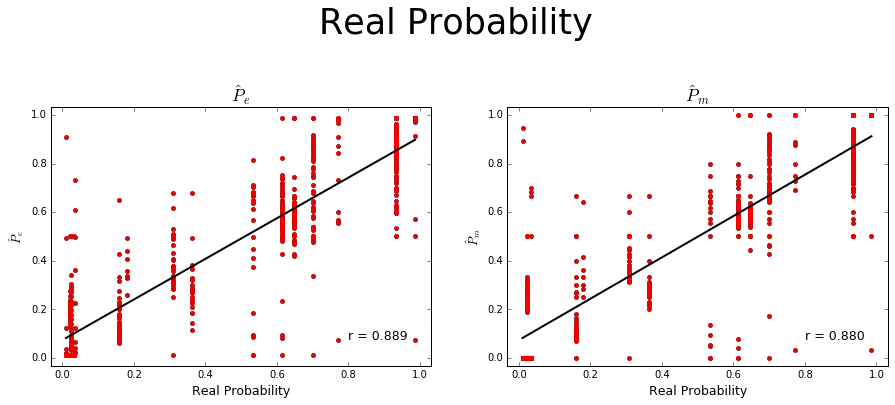

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(fig_width*2, (fig_width*1)/1.6180))
plt.subplots_adjust(hspace=0.4)
fig.suptitle("Real Probability", y=1.2, fontsize=t_titre*2)

for z, comparaison in enumerate(['$\hat{P}_{e}$', '$\hat{P}_{m}$']) :
   
    proba = full_proba
    proba_s = proba_sujet

    if z == 0 :
        axs[z].set_ylabel('$\hat{P}_{e}$', fontsize=t_label)
        sujet = p_hat_sujet_e
        full = full_p_hat_e
        y_1 = -0.032
        y_2 = 1.032

    if z == 1 :
        axs[z].set_ylabel('$\hat{P}_{m}$', fontsize=t_label)
        sujet = p_hat_sujet_m
        full = full_p_hat_m
        y_1 = -0.032
        y_2 = 1.032
        
    for x, color in enumerate(colors[:nb_sujet]):
        axs[z].scatter(proba_s[x], sujet[x], c=color, alpha=0.5, linewidths=0)

    slope, intercept, r_value, p_value, std_err = stats.linregress(proba, full)
    x_test = np.linspace(np.min(proba), np.max(proba), 100)
    fitLine = slope * x_test + intercept
    axs[z].plot(x_test, fitLine, c='k', linewidth=2)
    axs[z].text(0.8,y_1+(y_2-y_1)/10, 'r = %0.3f'%(r_value), fontsize=t_label)

    axs[z].axis([-0.032, 1.032, y_1, y_2])

    axs[z].set_title("%s"%(comparaison), fontsize=t_titre)
    axs[z].set_xlabel('Real Probability', fontsize=t_label)

## $\hat{P}_{e}$ and $\hat{P}_{m}$

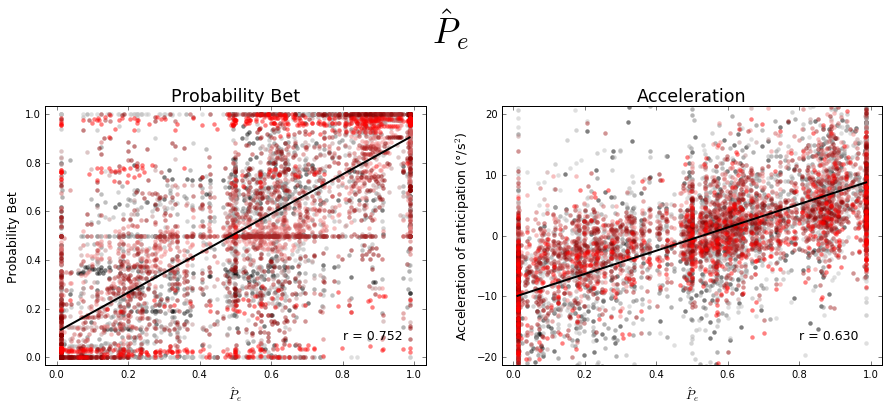

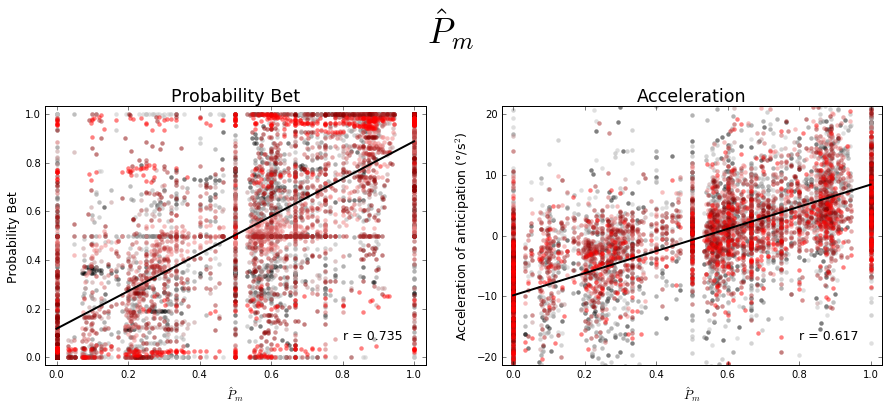

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(fig_width*2, (fig_width*1)/1.6180))
plt.subplots_adjust(hspace=0.4)
fig.suptitle("$\hat{P}_{e}$",y=1.2, fontsize=t_titre*2)

for z, comparaison in enumerate(['Probability Bet', 'Acceleration']) :

    proba = full_p_hat_e
    proba_s = p_hat_sujet_e

    if z == 0 :
        axs[z].set_ylabel('Probability Bet', fontsize=t_label)
        sujet = results_sujet
        full = full_results
        y_1 = -0.032
        y_2 = 1.032

    elif z == 1 :
        axs[z].set_ylabel('Acceleration of anticipation (°/s$^2$)', fontsize=t_label)
        sujet = va_sujet
        full = full_va
        y_1 = -21.28
        y_2 = 21.28


    for x, color in enumerate(colors[:nb_sujet]):
        axs[z].scatter(proba_s[x], sujet[x], c=color, alpha=0.5, linewidths=0)

    # masque les NAN
    proba = np.ma.masked_array(proba, mask=np.isnan(full)).compressed()
    full = np.ma.masked_array(full, mask=np.isnan(full)).compressed()
    slope, intercept, r_value, p_value, std_err = stats.linregress(proba, full)
    x_test = np.linspace(np.min(proba), np.max(proba), 100)
    fitLine = slope * x_test + intercept
    axs[z].plot(x_test, fitLine, c='k', linewidth=2)
    axs[z].text(0.8,y_1+(y_2-y_1)/10, 'r = %0.3f'%(r_value), fontsize=t_label)

    axs[z].axis([-0.032, 1.032, y_1, y_2])

    axs[z].set_title("%s"%(comparaison), fontsize=t_titre)
    axs[z].set_xlabel('$\hat{P}_{e}$', fontsize=t_label)
    
fig, axs = plt.subplots(1, 2, figsize=(fig_width*2, (fig_width*1)/1.6180))
plt.subplots_adjust(hspace=0.4)
fig.suptitle("$\hat{P}_{m}$",y=1.2, fontsize=t_titre*2)

for z, comparaison in enumerate(['Probability Bet', 'Acceleration']) :

    proba = full_p_hat_m
    proba_s = p_hat_sujet_m

    if z == 0 :
        axs[z].set_ylabel('Probability Bet', fontsize=t_label)
        sujet = results_sujet
        full = full_results
        y_1 = -0.032
        y_2 = 1.032

    elif z == 1 :
        axs[z].set_ylabel('Acceleration of anticipation (°/s$^2$)', fontsize=t_label)
        sujet = va_sujet
        full = full_va
        y_1 = -21.28
        y_2 = 21.28


    for x, color in enumerate(colors[:nb_sujet]):
        axs[z].scatter(proba_s[x], sujet[x], c=color, alpha=0.5, linewidths=0)

    # masque les NAN
    proba = np.ma.masked_array(proba, mask=np.isnan(full)).compressed()
    full = np.ma.masked_array(full, mask=np.isnan(full)).compressed()
    slope, intercept, r_value, p_value, std_err = stats.linregress(proba, full)
    x_test = np.linspace(np.min(proba), np.max(proba), 100)
    fitLine = slope * x_test + intercept
    axs[z].plot(x_test, fitLine, c='k', linewidth=2)
    axs[z].text(0.8,y_1+(y_2-y_1)/10, 'r = %0.3f'%(r_value), fontsize=t_label)

    axs[z].axis([-0.032, 1.032, y_1, y_2])

    axs[z].set_title("%s"%(comparaison), fontsize=t_titre)
    axs[z].set_xlabel('$\hat{P}_{m}$', fontsize=t_label)

TODO: connaissant la probabilité a priori de p_hat, on peut normaliser le poids de chaque point pour calculer le r2

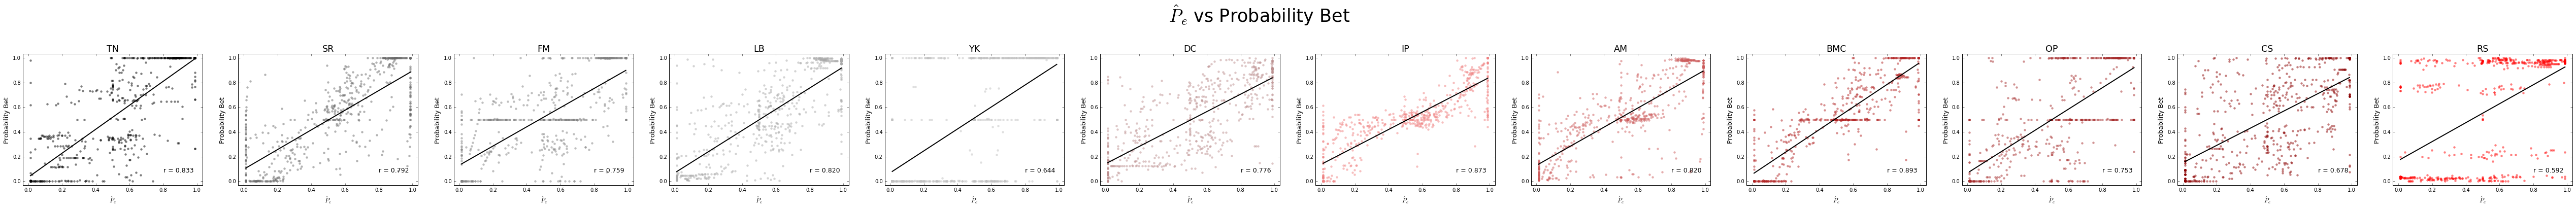

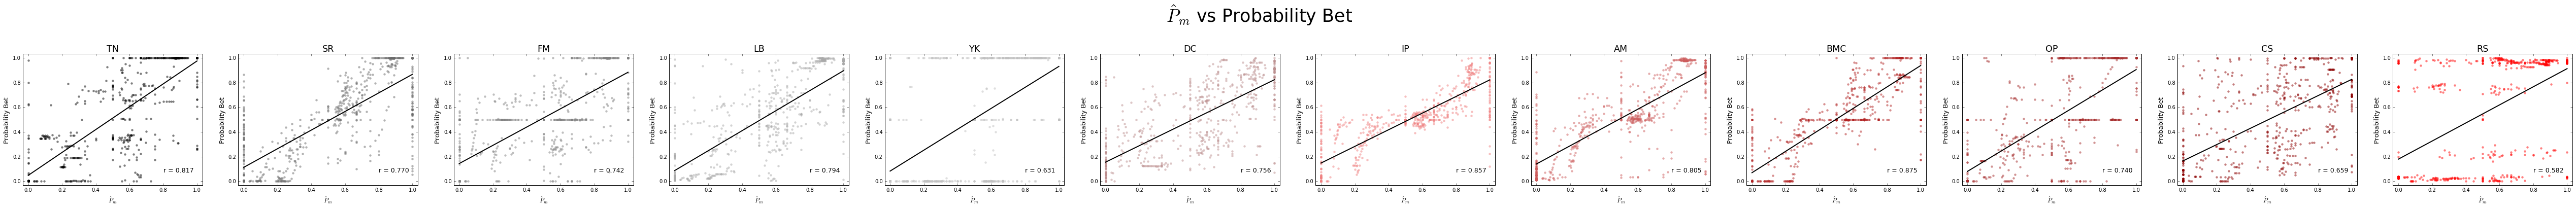

In [13]:
titre = " $\hat{P}_{e}$ vs Probability Bet"
y_1 = -0.032
y_2 = 1.032
proba = p_hat_sujet_e
para = results_sujet
x_label = '$\hat{P}_{e}$'
y_label = 'Probability Bet'
plot_sujet(proba=proba, para=para, titre=titre, y_1=y_1, y_2=y_2, x_label=x_label, y_label=y_label)

titre = " $\hat{P}_{m}$ vs Probability Bet"
proba = p_hat_sujet_m
x_label = '$\hat{P}_{m}$'
plot_sujet(proba=proba, para=para, titre=titre, y_1=y_1, y_2=y_2, x_label=x_label, y_label=y_label)

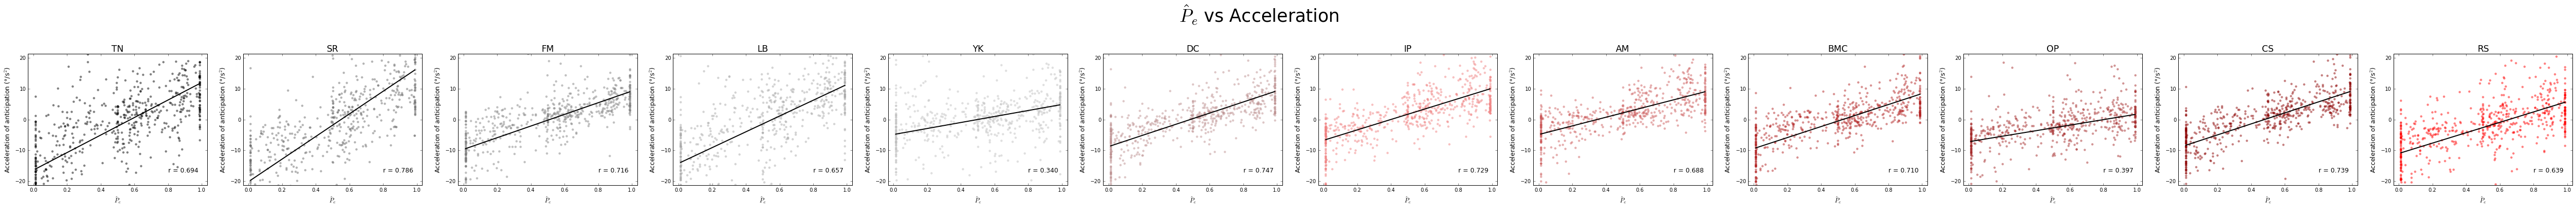

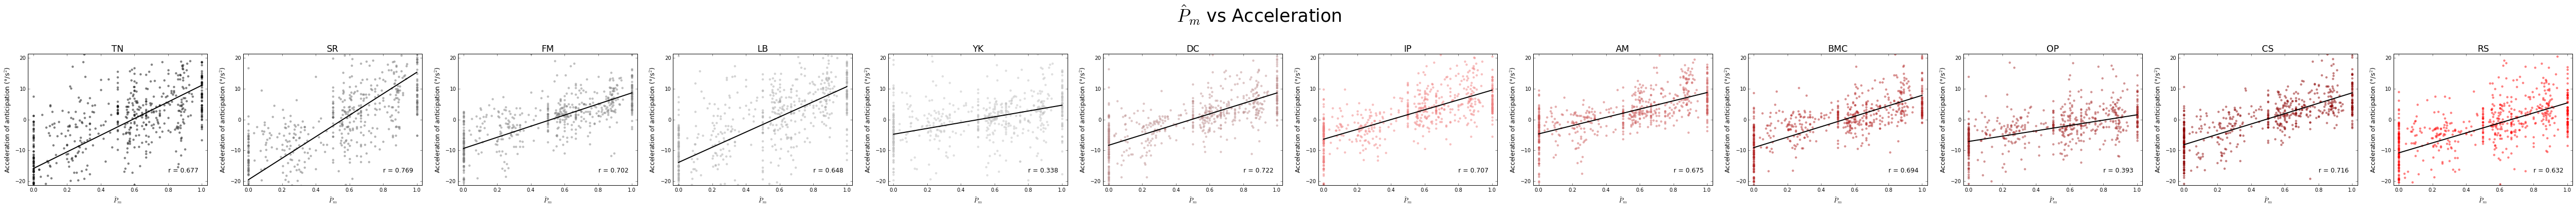

In [14]:
titre = "$\hat{P}_{e}$ vs Acceleration"
y_1 = -21.28
y_2 = 21.28
proba = p_hat_sujet_e
para = va_sujet
x_label = '$\hat{P}_{e}$'
y_label = 'Acceleration of anticipation (°/s$^2$)'
plot_sujet(proba=proba, para=para, titre=titre, y_1=y_1, y_2=y_2, x_label=x_label, y_label=y_label)

titre = "$\hat{P}_{m}$ vs Acceleration"
proba = p_hat_sujet_m
x_label = '$\hat{P}_{m}$'
plot_sujet(proba=proba, para=para, titre=titre, y_1=y_1, y_2=y_2, x_label=x_label, y_label=y_label)